In [120]:
import os
import os.path
import datetime as dt
import textwrap
import json
import pathlib as pth

import joblib
import pandas as pd
import numpy as np
import altair as alt
from altair.vega.v4 import Vega

import codemetrics as cm
import codemetrics.vega

%matplotlib inline
def retina():
    return {
        'config': {
            'view': {
                'height': 400,
                'width': 400 * 1.61,
            },
        }
    }
alt.themes.register('retina', retina)
alt.themes.enable('retina')

ThemeRegistry.enable('retina')

In [121]:
import importlib
#importlib.reload(cm)
#importlib.reload(cm.git)
#importlib.reload(cm.core)
#importlib.reload(cm.vega)
#importlib.reload(cm.cloc)
#importlib.reload(cm.internals)

In [122]:
disk = joblib.Memory(location=os.getenv('TEMP'), verbose=0)
get_cloc = disk.cache(cm.get_cloc)
get_git_log = disk.cache(cm.get_git_log)
year_ago = dt.datetime.now(tz=dt.timezone.utc) - dt.timedelta(365)
target_location = pth.Path.home() / 'Documents' / 'Github' / 'pandas'
cwd = os.path.abspath(os.path.curdir)
os.chdir(target_location)
get_cloc.clear()

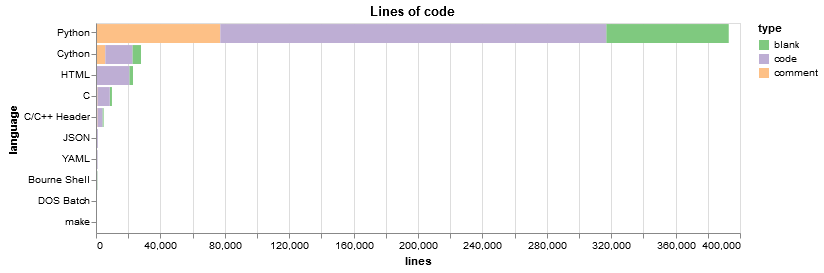

In [123]:
loc = get_cloc(cloc_program=pth.Path.home() / 'scripts' / 'cloc-1.64.exe')
loc_sum = loc.groupby('language').sum().reset_index().melt(id_vars=['language']).rename(columns={'variable': 'type', 'value': 'lines'})
alt.Chart(loc_sum).mark_bar().encode(
    x=alt.X('lines:Q'),
    y=alt.Y('language:N', sort=alt.EncodingSortField(field='lines', op='sum', order='descending')),
    color=alt.Color('type:N', scale=alt.Scale(scheme='accent')), 
    tooltip=['lines:Q', 'type:O'],
).properties(title='Lines of code')

In [124]:
log = get_git_log(path='.', after=year_ago, git_program='git.exe')
log['issue'] = log['message'].str.extract(r'\(#(\d+)\)')
log = pd.merge(log, loc[['path']], left_on='path', right_on='path')

[592fd6436] [Marc Garcia] [2018-11-11 23:36:29 +0000] [BUILD: Simplifying contributor dependencies (#23522)]
15	1	ci/requirements-optional-conda.txt => requirements-dev.txt


In [125]:
ages = cm.get_ages(log).groupby('path').min()[['age']].reset_index().merge(loc)  # FIXME BUG in get_ages.
ages['last_change'] = ages['age'].apply(lambda a: pd.to_datetime('today') - dt.timedelta(a))
ages['age_in_week'] = ages['age'].apply(lambda d: int(d / 7))
ages.head()

,path,age,language,blank,comment,code,last_change,age_in_week
0,.pep8speaks.yml,67.443209,YAML,3,4,12,2018-11-18 20:25:27.406918,9
1,.travis.yml,23.664517,YAML,15,20,83,2019-01-01 15:06:46.406918,3
2,Makefile,66.400072,make,7,0,19,2018-11-19 21:27:34.406918,9
3,asv_bench/asv.conf.json,5.931901,JSON,15,0,110,2019-01-19 08:41:44.406918,0
4,asv_bench/benchmarks/algorithms.py,15.839586,Python,41,2,102,2019-01-09 10:54:40.407876,2


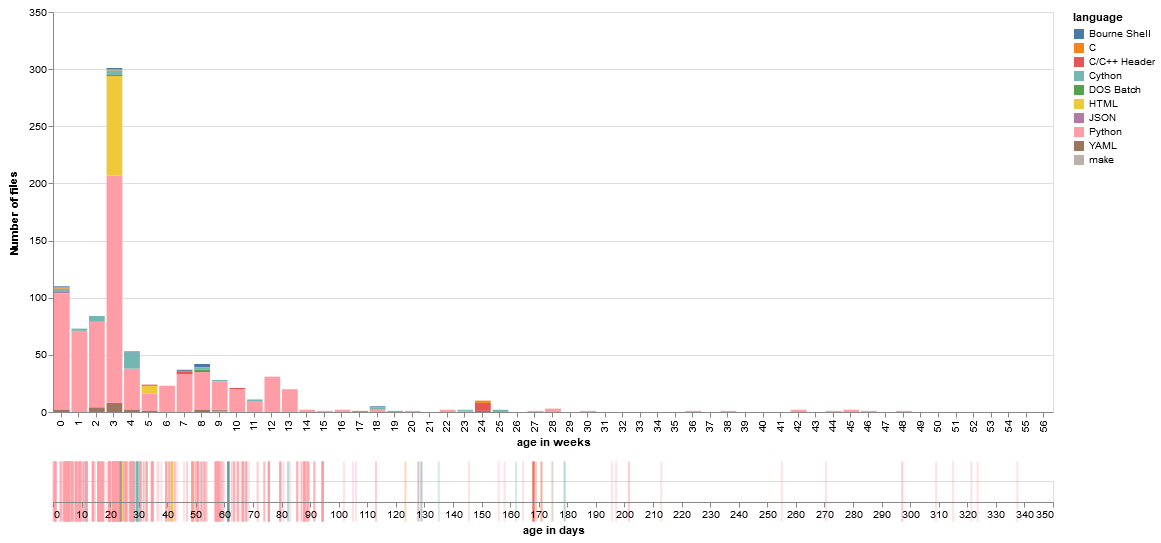

In [126]:
width = 1000
weeks = list(range(int(400 / 7)))
chart = alt.Chart(ages).encode(color='language')
top = chart.mark_bar().\
    encode(x=alt.X('age_agg:O', sort='ascending', title='age in weeks', scale=alt.Scale(domain=weeks)),
           y=alt.Y('count(path):Q', title='Number of files'),
           color=alt.Color('language', scale=alt.Scale(scheme='tableau10')),
           tooltip=['count(path)', 'language']
          ).\
    transform_calculate(age_agg='floor(datum.age / 7)').\
    properties(width=width)
bottom = chart.mark_tick(size=60, thickness=2, opacity=.3).\
    encode(x=alt.X('age:Q', title='age in days'),
           tooltip='path').properties(width=width)
alt.vconcat(top, bottom)

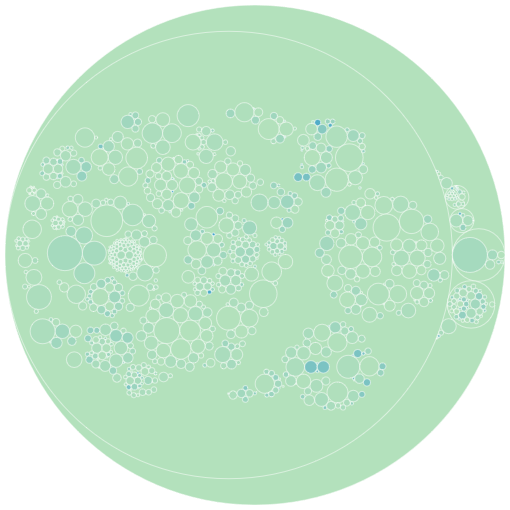

In [127]:
desc = cm.vega.vis_ages(ages, height=500, width=500)
Vega(desc)

In [128]:
hspots = cm.get_hot_spots(log, loc) 
hspots.query("language == 'Python'").sort_values(by=['changes', 'lines'], ascending=False).head()
hspots.head(10)

,language,path,blank,comment,lines,changes
0,HTML,pandas/tests/io/data/banklist.html,33,21,4832,2.0
1,HTML,doc/source/_static/banklist.html,33,21,4831,1.0
2,Python,pandas/tests/io/test_pytables.py,1171,521,3959,29.0
3,Python,pandas/io/pytables.py,927,961,3002,38.0
4,Python,pandas/tests/test_window.py,788,299,2986,21.0
5,Python,pandas/core/generic.py,1832,6306,2891,197.0
6,Python,pandas/tests/frame/test_indexing.py,731,312,2641,33.0
7,Python,pandas/tests/tseries/offsets/test_offsets.py,542,163,2438,28.0
8,Python,pandas/tests/test_strings.py,649,360,2417,23.0
9,Python,pandas/core/frame.py,1278,4376,2330,220.0


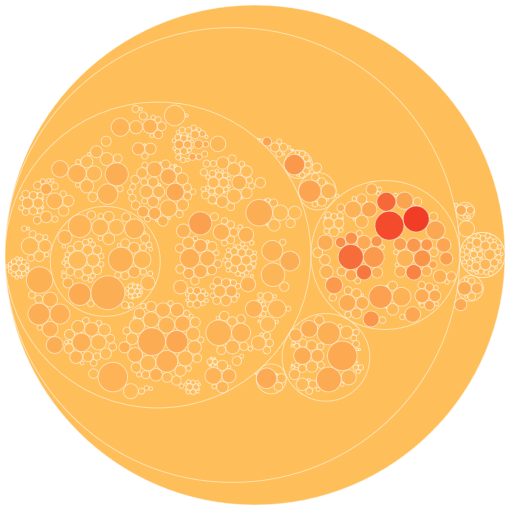

In [129]:
desc = cm.vega.vis_hot_spots(hspots.query("language == 'Python'"), width=500, height=500)
Vega(desc)

In [130]:
co_changes = cm.get_co_changes(log, by='path', on='issue').query('coupling > .6').sort_values(by=['changes', 'cochanges'], ascending=False)
co_changes.head()

,path,dependency,changes,cochanges,coupling
15832,pandas/core/indexes/period.py,pandas/core/indexes/datetimes.py,74,47,0.635135
16298,pandas/core/indexes/timedeltas.py,pandas/core/indexes/datetimes.py,69,54,0.782609
8100,pandas/core/arrays/datetimelike.py,pandas/core/arrays/datetimes.py,65,43,0.661538
8103,pandas/core/arrays/datetimelike.py,pandas/core/arrays/period.py,65,41,0.630769
8947,pandas/core/arrays/period.py,pandas/core/arrays/datetimelike.py,63,41,0.650794
